In [1]:
import sys
import numpy as np
import pandas as pd
import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from scipy import stats
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

## Model

In [149]:
# def garch_model(train, test, date_index, cut_date, num_of_predictions):
#     train = pd.DataFrame(train, index = date_index[date_index < cut_date]).dropna()
#     test = pd.DataFrame(test, index = date_index[date_index >= cut_date].dropna())
#     data = pd.concat([train, test], axis=0).astype('float64')
#     print(data)
#     basic_gm = arch_model(data.values, p=1, q=1, mean='Constant', #mean: 'AR', 'ARX', 'Constant', 'Zero', 'LS', 'HAR', 'HARX' 
#                           vol = 'ARCH', dist = 'normal') #'vol: 'Garch', 'ARCH', 'HARCH' #dist: 'normal','skewt','t'
#     start_loc = 0
#     end_loc = np.where(data.index >= test.index[0])[0].min()
#     forecasts = {} 
#     for i in range(1,num_of_predictions+1):
#         sys.stdout.write('.')
#         sys.stdout.flush()
#         res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off', update_freq = 5)
#         temp = res.forecast(horizon=1).variance#mean or variance (residual variance)
        
#         fcast = temp.iloc[i + end_loc - 1]
#         forecasts[fcast.name] = fcast
#     forecasts_df = pd.DataFrame(forecasts).T
#     return forecasts_df


In [208]:
def garch_model(train, test, data, num_of_predictions):
    basic_gm = arch_model(data.values, p=1, q=1, mean='constant', #mean: 'AR', 'ARX', 'Constant', 'Zero', 'LS', 'HAR', 'HARX' 
                          vol = 'ARCH', dist = 'normal') #'vol: 'Garch', 'ARCH', 'HARCH' #dist: 'normal','skewt','t'
    start_loc = 0
    end_loc = np.where(data.index >= test.index[0])[0].min()
    forecasts = {} 
    for i in range(1,num_of_predictions+1):
        sys.stdout.write('.')
        sys.stdout.flush()
        res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off', update_freq = 5)
        temp = res.forecast(horizon=1).variance #mean or variance (residual variance)        
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast
    forecasts_df = pd.DataFrame(forecasts).T
    return forecasts_df

## Evaluation

In [209]:
def evaluation_metrics(test_data, predictions):
    metrics = {}
    
    metrics['MAPE'] = mean_absolute_percentage_error(predictions,test_data)
    metrics['MSE'] = mean_squared_error(test_data,predictions)
    
    return metrics

## Pipeline

In [3]:
cap_list = ['nano','micro','small','medium','large','mega']

In [60]:
#Example
a_file = open('processed_data/' + 'mega' + '_train.pkl', "rb")
train_data = pickle.load(a_file)
a_file = open('processed_data/' + 'mega' + '_test.pkl', "rb")
test_data = pickle.load(a_file)

pd.DataFrame(test_data['AAPL'],columns=['date','return']).set_index(['date'])

In [202]:
stock_ticker = 'GOOGL'
cut_date = '2021-01-01'

train = pd.DataFrame(train_data[stock_ticker],columns=['date','return']).set_index(['date'])
test = pd.DataFrame(test_data[stock_ticker],columns=['date','return']).set_index(['date'])
data = pd.concat([train,test], axis=0).astype('float64')

# train = np.array(pd.DataFrame(train_data[stock_ticker]).dropna()[1])
# train_date = pd.DataFrame(train_data[stock_ticker]).dropna()[0]
# test = np.array(pd.DataFrame(test_data[stock_ticker]).dropna()[1])
# test_date = pd.DataFrame(test_data[stock_ticker]).dropna()[0]
# date_index = pd.concat([train_date,test_date], axis=0)
# date_index.name = None
# train = pd.DataFrame(train, index = date_index[date_index < cut_date]).dropna()
# test = pd.DataFrame(test, index = date_index[date_index >= cut_date].dropna())
# data = pd.concat([train, test], axis=0).astype('float64')

basic_gm = arch_model(data.values, p=1, q=1, mean='constant', vol = 'GARCH', dist = 'normal')
start_loc = 0
end_loc = np.where(data.index >= test.index[0])[0].min()
forecasts = {} 
for i in range(1,len(test)+1):
    sys.stdout.write('.')
    sys.stdout.flush()
    res = basic_gm.fit(first_obs=i, last_obs=i + end_loc, disp='off', update_freq = 5)
    temp = res.forecast(horizon=1).variance #mean or variance (residual variance)

    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
forecasts_df = pd.DataFrame(forecasts).T
forecasts_df

.............................................................................................................................................................................................................................................

,h.1
756,0.000254
757,0.000253
758,0.000321
759,0.000309
760,0.000345
...,...
988,0.000229
989,0.000329
990,0.000300
991,0.000278


In [203]:
evaluation_metrics(test['return'], forecasts_df['h.1'])

{'MAPE': 34.66765297201452, 'MSE': 0.00024287018531691238}

In [204]:
evaluation_metrics(abs(test['return']), forecasts_df['h.1']*100)

{'MAPE': 0.6554404865650807, 'MSE': 0.000474999458667974}

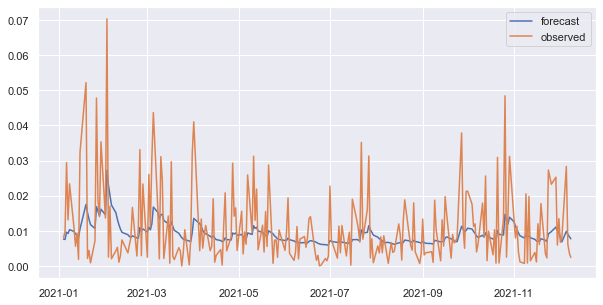

In [207]:
plt.figure(figsize=(10,5))
plt.plot(date_index[date_index >= cut_date].dropna(), forecasts_df['h.1']*30, label='forecast')
plt.plot(date_index[date_index >= cut_date].dropna(), abs(test['return']), label='observed')
plt.legend()
plt.show()

In [ ]:
metrics_df_concat = pd.DataFrame()
cut_date = '2021-01-01'

for cap_size in cap_list:
    result_metric_dict = {}
    
    a_file = open('processed_data/' + cap_size + '_train.pkl', "rb")
    train_data = pickle.load(a_file)
    
    a_file = open('processed_data/' + cap_size + '_test.pkl', "rb")
    test_data = pickle.load(a_file)
    
    
    for stock_ticker in train_data.keys():
        print(stock_ticker)
        train = pd.DataFrame(train_data[stock_ticker],columns=['date','return']).set_index(['date'])
        test = pd.DataFrame(test_data[stock_ticker],columns=['date','return']).set_index(['date'])
        data = pd.concat([train,test], axis=0).astype('float64')
        
        prediction = garch_model(train, test, data, len(test))
        result_metric_dict[stock_ticker] = evaluation_metrics(test['return'],prediction['h.1'])

    metrics_df = pd.DataFrame(result_metric_dict).T
    metrics_df['Cap_size'] = cap_size
    
    metrics_df_concat = metrics_df_concat.append(metrics_df)

WVVIP
.............................................................................................................................................................................................................................................CBIO
.............................................................................................................................................................................................................................................CYCCP
.............................................................................................................................................................................................................................................CLRB
.............................................................................................................................................................................................................................................NSYS
.........................

/Users/iriswei/opt/miniconda3/envs/newenv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/iriswei/opt/miniconda3/envs/newenv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/iriswei/opt/miniconda3/envs/newenv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


........................

/Users/iriswei/opt/miniconda3/envs/newenv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


.....................................LIXT
.............................................................................................................................................................................................................................................IDRA
.............................................................................................................................................................................................................................................REED
.............................................................................................................................................................................................................................................ZIVO
........................................................................................................................................................................................................................................

.............................................................................................................................................................................................................................................TANNI
.............................................................................................................................................................................................................................................BPOPM
.............................................................................................................................................................................................................................................EKSO
.............................................................................................................................................................................................................................................XBIO
..............................

.............................................................................................................................................................................................................................................BYFC
.............................................................................................................................................................................................................................................AESE
.............................................................................................................................................................................................................................................HSON
.............................................................................................................................................................................................................................................VIRC
................................

.............................................................................................................................................................................................................................................UONE
.............................................................................................................................................................................................................................................MINM
.............................................................................................................................................................................................................................................WVVI
.............................................................................................................................................................................................................................................MLVF
................................

.............................................................................................................................................................................................................................................GTIM
.............................................................................................................................................................................................................................................NWPX
.............................................................................................................................................................................................................................................TXMD
.............................................................................................................................................................................................................................................ADVM
................................

.............................................................................................................................................................................................................................................WABC
.............................................................................................................................................................................................................................................SNEX
.............................................................................................................................................................................................................................................IEA
.............................................................................................................................................................................................................................................HCCI
.................................

.............................................................................................................................................................................................................................................INSG
.............................................................................................................................................................................................................................................CAC
.............................................................................................................................................................................................................................................BLBD
.............................................................................................................................................................................................................................................OSPN
.................................

.............................................................................................................................................................................................................................................OZK
.............................................................................................................................................................................................................................................TXRH
.............................................................................................................................................................................................................................................CORT
.............................................................................................................................................................................................................................................UNIT
.................................

.............................................................................................................................................................................................................................................WEN
.............................................................................................................................................................................................................................................SKYW
.............................................................................................................................................................................................................................................CRUS
.............................................................................................................................................................................................................................................TOWN
.................................

.............................................................................................................................................................................................................................................INDB
.............................................................................................................................................................................................................................................EXEL
.............................................................................................................................................................................................................................................CWST
.............................................................................................................................................................................................................................................HMHC
................................

.............................................................................................................................................................................................................................................MDLZ
.............................................................................................................................................................................................................................................RGEN
.............................................................................................................................................................................................................................................LBRDA
.............................................................................................................................................................................................................................................INTU
...............................

.............................................................................................................................................................................................................................................ENTG
.............................................................................................................................................................................................................................................CSGP
.............................................................................................................................................................................................................................................MDB
.............................................................................................................................................................................................................................................

## Visualization

In [193]:
metrics_df_concat.groupby(by='Cap_size').describe()

MAPE                                                              \
         count      mean       std       min       25%       50%       75%   
Cap_size                                                                     
large     79.0  0.768381  0.066136  0.610571  0.721006  0.772362  0.820818   
medium    87.0  0.804260  0.057571  0.671571  0.763536  0.808250  0.845701   
mega      19.0  0.751347  0.101052  0.539003  0.708962  0.745027  0.779260   
micro     87.0  0.864571  0.062480  0.696787  0.820288  0.877625  0.912897   
nano      81.0  0.875387  0.126423  0.286880  0.871204  0.915159  0.944870   
small     92.0  0.831869  0.069665  0.621823  0.793371  0.840431  0.881948   

                     MSE                                                 \
               max count         mean           std       min       25%   
Cap_size                                                                  
large     0.900448  79.0     0.057359      0.289904  0.000099  0.001122   
medium    0.947349  87.0     0.070685      0.324078  0.000220  0.002437   
mega      0.961288  19.0     0.021904      0.056280  0.000088  0.000544   
micro     0.968137  87.0     0.461261      1.723803  0.000341  0.005863   
nano      0.988579  81.0  4202.164714  37553.876431  0.000012  0.026726   
small     0.973124  92.0     0.170073      0.588176  0.000082  0.003212   

                                             
               50%       75%            max  
Cap_size                                     
large     0.002725  0.006504       2.487929  
medium    0.005342  0.021557       2.633275  
mega      0.001154  0.002835       0.227669  
micro     0.044033  0.151722      15.326233  
nano      0.238452  1.045747  338008.372744  
small     0.013300  0.082133       4.726114

In [154]:
metrics_df_concat[metrics_df_concat['Cap_size'] == 'mega']

,MAPE,MSE,Cap_size
AVGO,0.772450,0.001778,mega
PYPL,0.747909,0.002560,mega
PEP,0.602757,0.000088,mega
GOOG,0.715008,0.000536,mega
NVDA,0.865975,0.079095,mega
TSLA,0.951337,0.227669,mega
COST,0.539003,0.000124,mega
QCOM,0.784858,0.002817,mega
GOOGL,0.711672,0.000552,mega
ADBE,0.746469,0.001154,mega


### MSE

<AxesSubplot:xlabel='MSE', ylabel='Cap_size'>

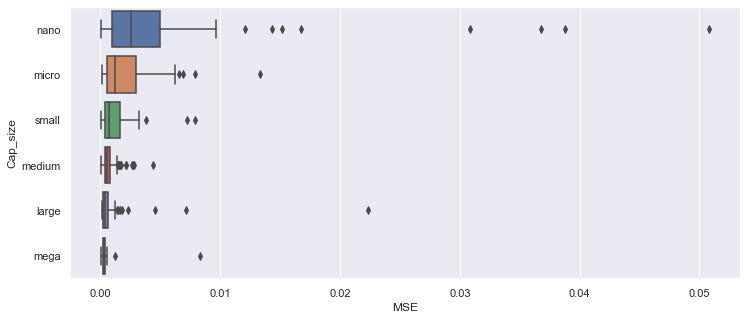

In [51]:
#test vs prediciton
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MSE']<0.1]
sns.set(rc = {'figure.figsize':(12,5)})
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MSE'
            ,y = 'Cap_size'
            )

<AxesSubplot:xlabel='MSE', ylabel='Cap_size'>

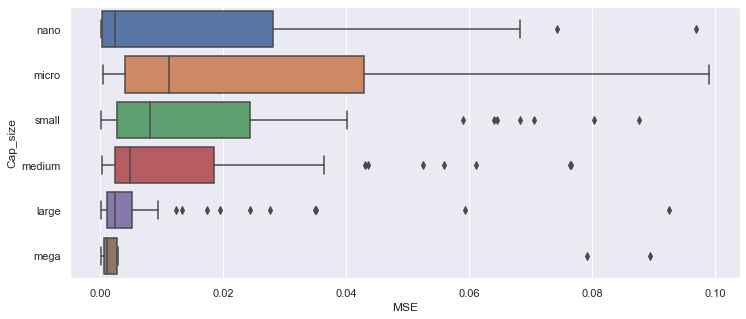

In [155]:
#abs(test) vs prediciton*100
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MSE']<0.1]
sns.set(rc = {'figure.figsize':(12,5)})
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MSE'
            ,y = 'Cap_size'
            )

### MAPE

<AxesSubplot:xlabel='MAPE', ylabel='Cap_size'>

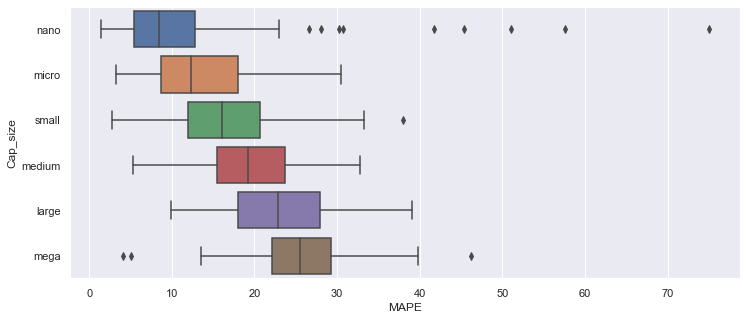

In [52]:
#test vs prediciton
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MAPE']<100]
sns.set(rc = {'figure.figsize':(12,5)})
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,y = 'Cap_size'
            )
plt.xscale('log')

<AxesSubplot:xlabel='MAPE', ylabel='Cap_size'>

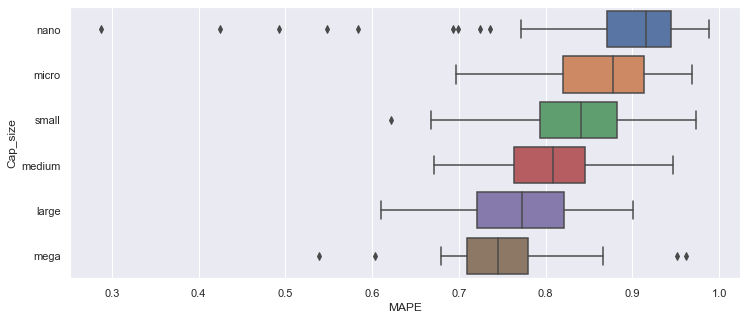

In [157]:
#abs(test) vs prediciton*100
metrics_df_concat_truncated = metrics_df_concat[metrics_df_concat['MAPE']<100]
sns.set(rc = {'figure.figsize':(12,5)})
sns.boxplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,y = 'Cap_size'
            )
#plt.xscale('log')

<AxesSubplot:xlabel='MAPE', ylabel='Count'>

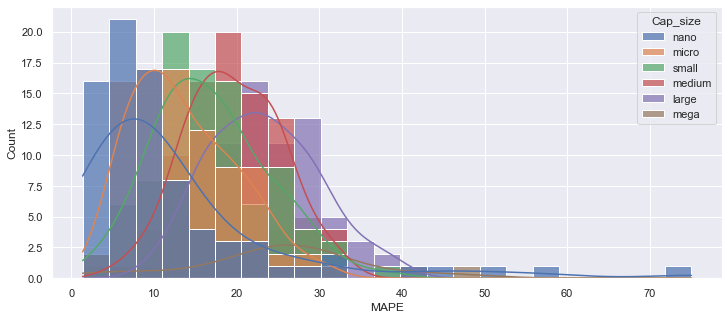

In [55]:
sns.histplot(data = metrics_df_concat_truncated
            ,x = 'MAPE'
            ,alpha = .7
            ,hue = 'Cap_size'
            ,kde=True
            )

In [56]:
metrics_df_concat.groupby('Cap_size').mean().reindex(cap_list)

,MAPE,MSE
Cap_size,,
nano,12.597694,0.423630
micro,13.561959,0.002140
small,16.840061,0.001193
medium,19.603634,0.000774
large,23.236964,0.000912
mega,24.965282,0.000756
